In [26]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from numpy import random
from scipy.stats import multivariate_normal, pearsonr
import warnings

warnings.filterwarnings("ignore")

In [27]:
a = [0,1,2,3,4,5,6,7,8,9]

In [28]:
for i in range(10):
    print(random.choice(a,len(a)))

[9 8 0 3 3 8 2 8 5 3]
[6 7 4 2 3 7 5 9 6 1]
[2 0 2 9 5 1 6 9 3 8]
[1 2 0 4 6 9 7 6 4 4]
[7 8 8 4 0 1 9 7 8 9]
[1 7 4 5 8 1 4 2 3 9]
[5 8 8 9 0 6 8 9 4 0]
[5 5 5 1 6 3 7 4 8 1]
[3 9 1 1 7 5 8 0 0 4]
[2 7 8 8 9 7 5 1 2 9]


In [29]:
N = np.linspace(1,40,100)

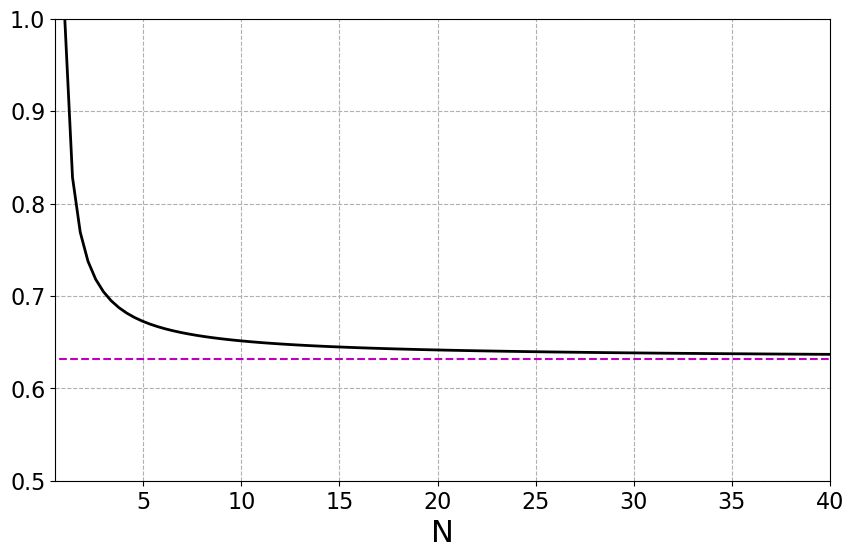

In [30]:
plt.figure(figsize=(10,6))
plt.plot(N, 1-(1-1/N)**N,'k',linewidth=2)
plt.hlines(1-1/np.e,-1,40,'m',linestyle='--')
plt.xlim(0.5,40)
plt.ylim(0.5,1.0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('N',fontsize=22)
plt.grid(linestyle='--')

# Bootstrap example

In [31]:
A = multivariate_normal( mean=[0,0], cov=[[1.0, 0.7], [0.7, 1.0]] )

In [32]:
sample = A.rvs(size=100)

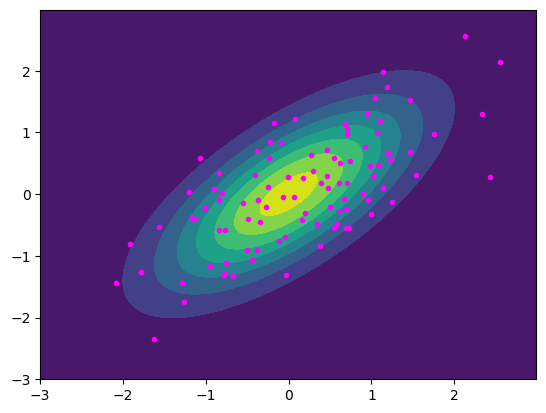

In [33]:
x = sample[:,0]
y = sample[:,1]

lim = 3
xgrid, ygrid = np.mgrid[-lim:lim:.01, -lim:lim:.01]
pos = np.dstack((xgrid, ygrid))
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(xgrid, ygrid, A.pdf(pos))
ax2.scatter(x=x,y=y,color='magenta',marker='.')

In [34]:
rsamp,_ = pearsonr(sample[:,0],sample[:,1])

In [35]:
rsamp

0.6819397480335647

# Do this many times

In [36]:
# Create random variables
rsamp = np.empty(1000)

for i in range(1000):
    sample = A.rvs(size=100)
    rsamp[i],_ = pearsonr(sample[:,0],sample[:,1])
    
print("%.4f +/- %.4f" % (rsamp.mean(), rsamp.std()))

0.6992 +/- 0.0548


# Do it with bootstrap

In [37]:
data = A.rvs(size=100)

rsamp_bs = np.empty(1000)
for i in range(1000):
    ind = np.random.choice(range(len(data)),len(data))
    sample = data[ind,:]
    rsamp_bs[i],_ = pearsonr(sample[:,0],sample[:,1])

print("%.4f +/- %.4f" % (rsamp_bs.mean(), rsamp_bs.std()))

0.7115 +/- 0.0495


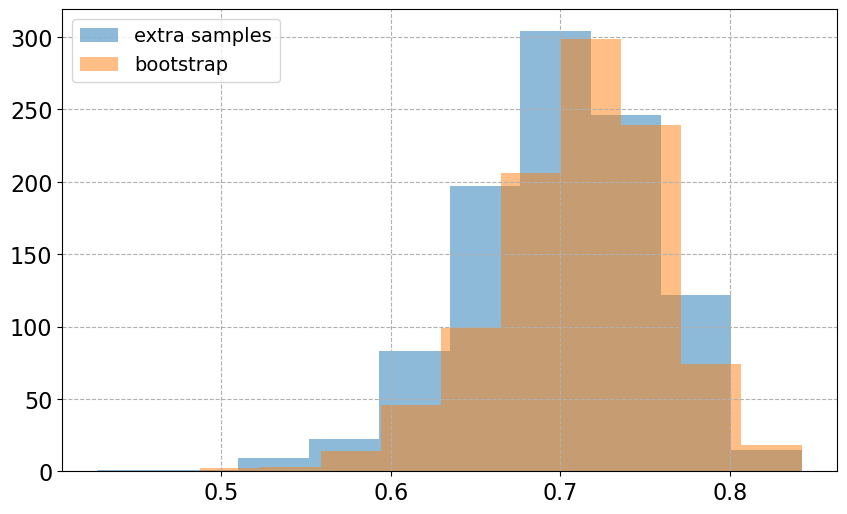

In [38]:
plt.figure(figsize=(10,6))
plt.hist(rsamp,alpha=0.5,label='extra samples')
plt.hist(rsamp_bs,alpha=0.5,label='bootstrap')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--')
plt.legend(fontsize=14)

# Bagging

In [39]:
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## Test/train split

In [40]:
iris = datasets.load_iris()
X = iris.data[50:,[1,2]]
y = iris.target[50:]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
ntest = len(X_test)

In [42]:
num_trees = 1000
ntrain = len(X_train)
all_acc = np.empty(num_trees)
y_pred = np.empty((num_trees,ntest))

trees = list()

for i in range(num_trees):
    
    # bootstrap sample the training data
    ind = np.random.choice(range(ntrain),ntrain)
    X_bs = X_train[ind,:]
    y_bs = y_train[ind]
    
    # train a new decision tree
    tree = DecisionTreeClassifier().fit(X_bs,y_bs)
    trees.append(tree)
    
    # test the tree
    y_pred[i,:] = tree.predict(X_test)
    all_acc[i] = accuracy_score(y_test,y_pred[i,:])

([], [])

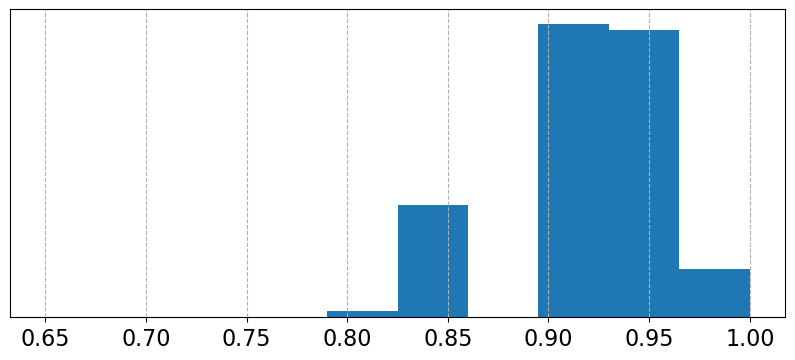

In [43]:
plt.figure(figsize=(10,4))
plt.hist(all_acc)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--')
plt.yticks([])

In [44]:
all_acc.mean()

0.9168

In [45]:
y_ensemble = scipy.stats.mode(y_pred).mode
accuracy_score( y_test, y_ensemble )

0.9

# Bagging in scikitlearn

In [46]:
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier( DecisionTreeClassifier(), n_estimators=500)
model.fit(X_train, y_train)
accuracy_score( y_test, model.predict(X_test) )

0.95

# OOB

In [47]:
model = BaggingClassifier( DecisionTreeClassifier(), n_estimators=500, oob_score=True)
model.fit(X_train, y_train)
model.oob_score_

0.875

In [48]:
max_trees = 50
acc = np.empty(max_trees)
oob = np.empty(max_trees)
for ntrees in range(1,max_trees):
    model = BaggingClassifier( DecisionTreeClassifier(), n_estimators=ntrees, oob_score=True)
    model.fit(X_train, y_train)
    acc[ntrees] = accuracy_score( y_test, model.predict(X_test) )
    oob[ntrees] = model.oob_score_
    

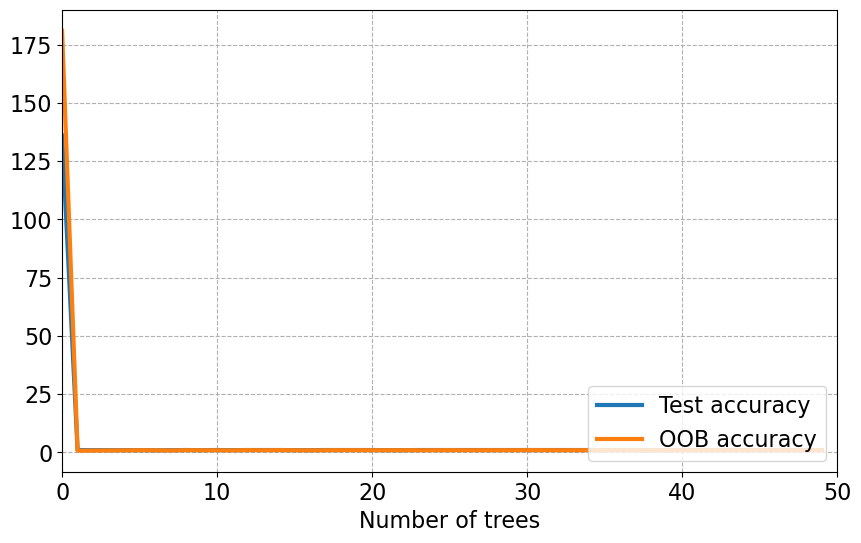

In [49]:
plt.figure(figsize=(10,6))
plt.plot(range(max_trees),acc, linewidth=3, label='Test accuracy')
plt.plot(range(max_trees),oob, linewidth=3, label='OOB accuracy')
plt.xlim(0,50)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='--')
plt.xlabel('Number of trees',fontsize=16)
plt.legend(fontsize=16, loc='lower right')